In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/microsoft-catsvsdogs-dataset/readme[1].txt
/kaggle/input/microsoft-catsvsdogs-dataset/MSR-LA - 3467.docx
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/7981.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/6234.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/1269.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/3863.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/6241.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/10304.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/623.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/2193.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/11925.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/3750.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/11378.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/2008.jpg
/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/10730.jpg
/kaggle/input/micros

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D, MaxPooling2D, Flatten
import keras_tuner as kt
from tensorflow.keras import layers, models

2025-05-10 11:59:30.653573: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746878371.044696     408 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746878371.165458     408 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import os
import shutil
import warnings
import numpy as np
from PIL import Image, UnidentifiedImageError
import tensorflow as tf

def clean_dataset(directory, valid_exts={'.jpg', '.jpeg', '.png'}):
    total, deleted = 0, 0
    for root, _, files in os.walk(directory):
        for fname in files:
            total += 1
            path = os.path.join(root, fname)
            ext = os.path.splitext(fname.lower())[1]

            # Delete non-image files
            if ext not in valid_exts:
                os.remove(path)
                deleted += 1
                continue

            # Try to open image
            try:
                with Image.open(path) as img:
                    img.verify()  # Check if corrupted
            except (UnidentifiedImageError, OSError, ValueError):
                os.remove(path)
                deleted += 1

    print(f"Checked {total} files.")
    print(f"Deleted {deleted} corrupt or invalid images.")



In [4]:
src_dir = '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages'
new_src_dir = '/kaggle/working/PetImages'

if not os.path.exists(new_src_dir):
    shutil.copytree(src_dir, new_src_dir)
    print("Dataset copied to new directory")

In [5]:
def resave_clean_images(directory):
    for root, _, files in os.walk(directory):
        for fname in files:
            path = os.path.join(root, fname)
            try:
                with Image.open(path) as img:
                    img = img.convert("RGB")  # Force RGB
                    img.save(path, format='JPEG', quality=95)
            except Exception:
                os.remove(path)  # Delete if it can't be re-saved

In [6]:
cat_src_dir='/kaggle/working/PetImages/Cat'
dog_src_dir='/kaggle/working/PetImages/Dog'
clean_dataset(cat_src_dir)
resave_clean_images(cat_src_dir)
clean_dataset(dog_src_dir)
resave_clean_images(dog_src_dir)

Checked 12499 files.
Deleted 0 corrupt or invalid images.
Checked 12499 files.
Deleted 0 corrupt or invalid images.


In [7]:
import os
import random

def split_image_data(
    src_dir,
    target_dir,
    split_ratio=0.2,
    seed=42
):
    random.seed(seed)
    categories = os.listdir(src_dir)
    
    for category in categories:
        category_path = os.path.join(src_dir, category)
        images=os.listdir(category_path)
        random.shuffle(images)
        split_index=int(len(images)*(1-split_ratio))
        
        train_images=images[:split_index]
        val_images=images[split_index:]
        
        train_dir = os.path.join(target_dir, 'train', category)
        val_dir = os.path.join(target_dir, 'val', category)
        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(val_dir, exist_ok=True)
        
        for img in train_images:
            src = os.path.join(category_path, img)
            dest = os.path.join(train_dir,img)
            shutil.copy2(src,dest)

        for img in val_images:
            src = os.path.join(category_path, img)
            dest = os.path.join(val_dir, img)
            shutil.copy2(src, dest)

    print("Done splitting")

In [8]:
split_image_data(
    src_dir = new_src_dir,
    target_dir= 'data',
    split_ratio=0.2
)

Done splitting


In [9]:
image_size = (128,128)
batch_size = 32
data_dir = "data"

ds_train = keras.utils.image_dataset_from_directory(
    directory = os.path.join(data_dir,'train'),
    labels='inferred',
    label_mode='binary',
    batch_size = batch_size,
    image_size= image_size,
    shuffle=True,
)

ds_val = keras.utils.image_dataset_from_directory(
    directory = os.path.join(data_dir, 'val'),
    labels='inferred',
    label_mode='binary',
    batch_size = batch_size,
    image_size = image_size,
    shuffle=False,
)


Found 19998 files belonging to 2 classes.


I0000 00:00:1746878504.375274     408 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746878504.375939     408 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 5000 files belonging to 2 classes.


In [10]:
def preprocess(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image,label

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
])

def augment(image, label):
    image = data_augmentation(image)
    return image, label
    

**AUTOTUNE** automatically figures out the best number of elements to prefetch or parallel map based on the hardware. Basically it maximizes GPU/CPU utilization to get the best performance

**prefetch(buffer_size=AUTOTUNE** prepares next batch of data while current batch is being processed by the model

**cache()** caches the dataset in memory after first epoch. So next epochs can fetch data  instantly from memory. Though it speeds up the training, it may eat up a huge portion of RAM



In [11]:
AUTOTUNE = tf.data.AUTOTUNE

ds_train=(
    ds_train
    .map(preprocess)
    .shuffle(1000)
    .prefetch(buffer_size=AUTOTUNE)
)

ds_val = (
    ds_val
    .map(preprocess)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

In [12]:
model = models.Sequential([
    layers.Conv2D(32,(3,3), activation='relu',input_shape=(128,128,3)),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(128,(3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(256,(3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(1,activation='sigmoid')

    
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [14]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,568,321 (5.98 MB)

 Trainable params: 1,568,321 (5.98 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=10
)

Epoch 1/10


I0000 00:00:1746878604.947695     454 service.cc:148] XLA service 0x7ec524010c50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746878604.949186     454 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746878604.949209     454 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746878605.379135     454 cuda_dnn.cc:529] Loaded cuDNN version 90300


  9/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5037 - loss: 31.2883 

I0000 00:00:1746878609.728240     454 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 25ms/step - accuracy: 0.5451 - loss: 2.1910 - val_accuracy: 0.7114 - val_loss: 0.5752
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.6963 - loss: 0.5794 - val_accuracy: 0.7568 - val_loss: 0.5144
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.7524 - loss: 0.5036 - val_accuracy: 0.7852 - val_loss: 0.4610
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.7997 - loss: 0.4366 - val_accuracy: 0.8234 - val_loss: 0.3795
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.8430 - loss: 0.3579 - val_accuracy: 0.8440 - val_loss: 0.3482
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.8622 - loss: 0.3189 - val_accuracy: 0.8658 - val_loss: 0.3178
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.8850 - loss: 0.2739 - val_accuracy: 0.8682 - val_loss: 0.3152
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.9076 - loss: 0.2238 - val_accurac

In [22]:
import matplotlib.pyplot as plt

def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14,5))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label='Training accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training vs Validation Accuracy')
    
    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label='Training loss')
    plt.plot(epochs_range, val_loss, label='Validation loss')
    plt.legend(loc='upper right')
    plt.title('Training vs Validation loss')

    plt.show()

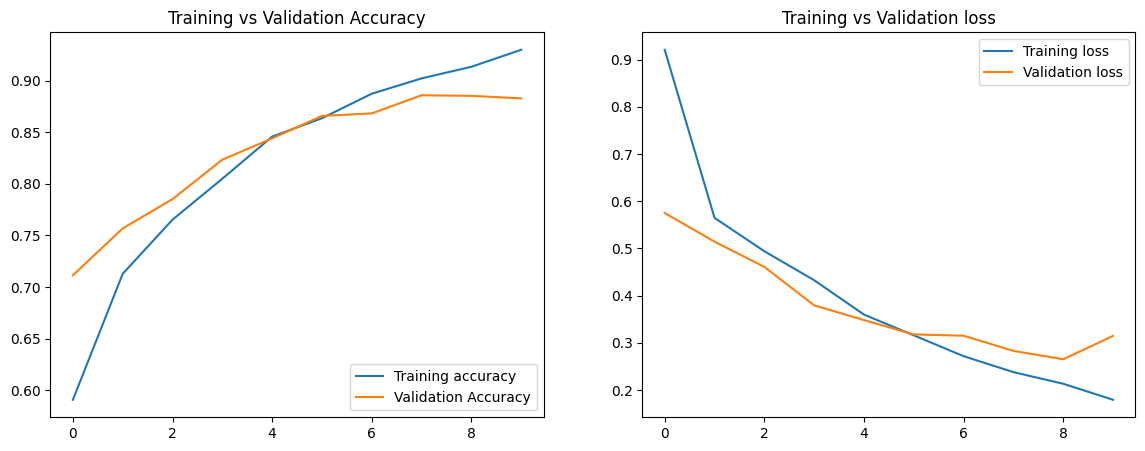

In [23]:
plot_training(history)